In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage
sys.path.append("../src")
import exlib
from exlib.datasets.cholecystectomy import CholecDataset, CholecModel, CholecMetric

## Overview
* The objective is to predict the **go/nogo** regions (safe, unsafe).
* The higher-level features are the **organs** (liver, gallblader, and hepatocystic triangle).

## Load datasets and pre-trained models

In [2]:
dataset = CholecDataset(split="all_data")
gonogo_model = CholecModel.from_pretrained("BrachioLab/cholecystectomy_gonogo").eval()

## Dataset samples and model predictions
Primary task: predict the safe/unsafe regions

In [3]:
sample = dataset[7] # Lucky number
image, gonogo, organs = sample["image"], sample["gonogo"], sample["organs"]
with torch.no_grad():
    gonogo_pred = gonogo_model(image[None,...]).logits[0].argmax(dim=0)

<Figure size 640x480 with 0 Axes>

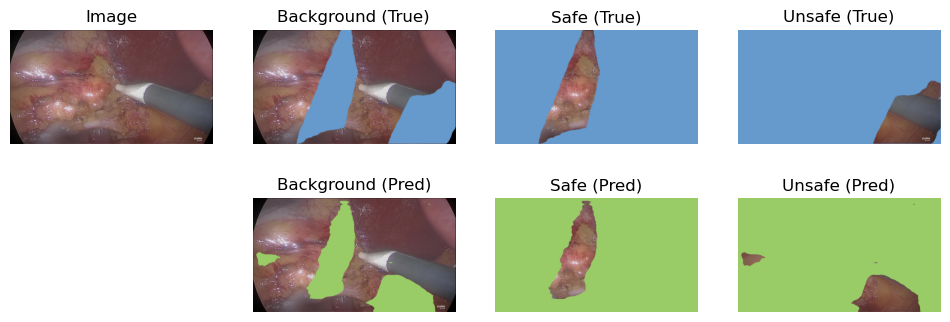

In [4]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    ["image", "gng_t0", "gng_t1", "gng_t2"],
    [".", "gng_p0", "gng_p1", "gng_p2"],
], figsize=(12,4))

for _, a in ax.items(): a.set_axis_off()
gng_titles = ["Background", "Safe", "Unsafe"]
C1 = torch.tensor([0.4, 0.6, 0.8]).view(3,1,1)
C2 = torch.tensor([0.6, 0.8, 0.4]).view(3,1,1)

ax["image"].imshow(image.numpy().transpose(1,2,0))
ax["image"].set_title("Image")

for i in range(3):
    mask_t = (gonogo == i).unsqueeze(0)
    mask_p = (gonogo_pred == i).unsqueeze(0)
    ax[f"gng_t{i}"].imshow(((image * mask_t) + (~mask_t * C1)).numpy().transpose(1,2,0))
    ax[f"gng_p{i}"].imshow(((image * mask_p) + (~mask_p * C2)).numpy().transpose(1,2,0))
    ax[f"gng_t{i}"].set_title(f"{gng_titles[i]} (True)")
    ax[f"gng_p{i}"].set_title(f"{gng_titles[i]} (Pred)")


## Expert-specified higher-level features: organs
Identifying key anatomical structures is an important step for surgeons

<Figure size 640x480 with 0 Axes>

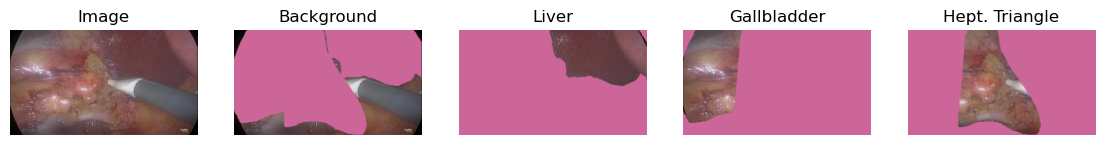

In [5]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    ["image", "org_t0", "org_t1", "org_t2", "org_t3"],
], figsize=(14,4))

for _, a in ax.items(): a.set_axis_off()
org_titles = ["Background", "Liver", "Gallbladder", "Hept. Triangle"]
C3 = torch.tensor([0.8, 0.4, 0.6]).view(3,1,1)

ax["image"].imshow(image.numpy().transpose(1,2,0))
ax["image"].set_title("Image")

for i in range(4):
    mask_t = (organs == i).unsqueeze(0)
    ax[f"org_t{i}"].imshow(((image * mask_t) + (~mask_t * C3)).numpy().transpose(1,2,0))
    ax[f"org_t{i}"].set_title(f"{org_titles[i]}")

## How well are the higher-level feature alignments?
Let's define the following high-level feature extractors for comparison:
* gridding
* quickshift
* watershed

In [6]:
class GridGroups(nn.Module):
    # Let's assume image is 360x640 and make 40x40 grids (i.e., 9x16 partitions)
    def __init__(self):
        super().__init__()

    def forward(self, x):
        N, _, _, _ = x.shape
        mask_small = torch.tensor(range(9*16)).view(1,1,9,16).repeat(N,1,1,1)
        mask_big = F.interpolate(mask_small.float(), scale_factor=40).round().long()
        return mask_big.view(N,360,640)

In [7]:
class QuickShiftGroups(nn.Module):
    # Use quickshift to perform image segmentation
    def __init__(self, kernel_size=10, max_dist=20, sigma=5, max_segs=40):
        super().__init__()
        self.kernel_size = kernel_size
        self.max_dist = max_dist
        self.sigma = sigma
        self.max_segs = max_segs

    def quickshift(self, image):
        # image is (C,H,W)
        image_np = image.numpy().transpose(1,2,0)
        segs = skimage.segmentation.quickshift(image_np, kernel_size=self.kernel_size, max_dist=self.max_dist, sigma=self.sigma)
        segs = torch.tensor(segs)
        segs[segs >= self.max_segs] = self.max_segs - 1
        return segs.long() # (H,W) of integers

    def forward(self, x):
        # x: (N,C,H,W)
        segs = torch.stack([self.quickshift(xi.cpu()) for xi in x]) # (N,H,W)
        return segs.to(x.device)

In [8]:
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

class WatershedGroups(nn.Module):
    def __init__(self, fp_size=10, min_dist=20, compactness=10, max_segs=64):
        """
        compactness: Higher values result in more regularly-shaped watershed basins.
        """
        super().__init__()
        self.fp_size = fp_size
        self.min_dist = min_dist
        self.compactness = compactness
        self.max_segs = max_segs

    def watershed(self, image):
        # image is (C,H,W)
        image = (image.mean(dim=0).numpy() * 255).astype(np.uint8)
        distance = ndi.distance_transform_edt(image)
        coords = peak_local_max(
            distance,
            min_distance=self.min_dist,
            footprint=np.ones((self.fp_size,self.fp_size)),
            labels=image,
        )
        # coords = peak_local_max(distance, min_distance=10, labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        segs = skimage.segmentation.watershed(
            -distance,
            markers,
            mask=image,
            compactness = self.compactness
        )
        # segs = skimage.segmentation.watershed(image_np, kernel_size=self.kernel_size, max_dist=self.max_dist, sigma=self.sigma)
        segs = torch.tensor(segs)
        div_by = (segs.unique().max() / self.max_segs).long().item() + 1
        segs = segs // div_by
        return segs.long() # (H,W) of integers

    def forward(self, x):
        # x: (N,C,H,W)
        segs = torch.stack([self.watershed(xi.cpu()) for xi in x]) # (N,H,W)
        return segs.to(x.device)

### ... and run the comparisons

In [ ]:
metric = CholecMetric()
grid_groups = GridGroups()
qshift_groups = QuickShiftGroups()
watershed_groups = WatershedGroups()
torch.manual_seed(1234)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
grid_scores, qshift_scores, watershed_scores = [], [], []
for i, item in enumerate(tqdm(dataloader)):
    image = item["image"]
    with torch.no_grad():
        organs_masks = F.one_hot(item["organs"]).permute(0,3,1,2)
        grid_masks = F.one_hot(grid_groups(image)).permute(0,3,1,2)
        qshift_masks = F.one_hot(qshift_groups(image)).permute(0,3,1,2)
        watershed_masks = F.one_hot(watershed_groups(image)).permute(0,3,1,2)
        
        grid_score = metric(grid_masks, organs_masks) # (N,H,W)
        qshift_score = metric(qshift_masks, organs_masks)
        watershed_score = metric(watershed_masks, organs_masks)
        grid_scores.append(grid_score.mean(dim=(1,2)))
        qshift_scores.append(qshift_score.mean(dim=(1,2)))
        watershed_scores.append(watershed_score.mean(dim=(1,2)))
    if i > 10:
        break

grid_scores = torch.cat(grid_scores)
qshift_scores = torch.cat(qshift_scores)
watershed_scores = torch.cat(watershed_scores)

print(f"Avg alignment of grid groups: {grid_scores.mean():.4f}")
print(f"Avg alignment of qshift groups: {qshift_scores.mean():.4f}")
print(f"Avg alignment of watershed groups: {watershed_scores.mean():.4f}")

  4%|▍         | 11/254 [06:19<2:18:53, 34.30s/it]